In [1]:
import numpy as np
import pandas as pd 

from deepymod.DeepMoD import DeepMoD
from deepymod.library_functions import library_1D
from deepymod.utilities import library_matrix_mat, print_PDE

import matplotlib.pyplot as plt
plt.style.use('seaborn-notebook')

np.random.seed(42)  # setting seed for randomisation

Set the noise level, number of samples, architecture and strength of the $L_1$ Penalty

In [2]:
noise_level = 0.05
number_of_samples = 1000
layers = [2, 20, 20, 20, 20, 20, 1]
l1 = 10**-6

In [3]:
# %%Importing and preparing data
data = np.load('data/burgers.npy').item()

X = np.transpose((data['x'].flatten(), data['t'].flatten()))
y = np.real(data['u']).reshape((data['u'].size, 1))
y_noisy = y + noise_level * np.std(y) * np.random.randn(y.size, 1)

idx = np.random.permutation(y.size)
X_train = X[idx, :][:number_of_samples]
y_train = y[idx, :][:number_of_samples]

Configure DeepMoD

In [6]:
config = {'layers': layers, 'lambda': l1}
library_config = {'total_terms': 12, 'deriv_order': 3, 'poly_order': 2}
train_opts = {'max_iterations': 10000, 'grad_tol':10**-7, 'learning_rate': 0.002, 'beta1': 0.99, 'beta2': 0.999, 'epsilon': 10**-8}
output_opts = {'output_directory': 'burgers_output/', 'X_predict': X}

Running DeepMoD

In [7]:
sparse_vectors, denoised = DeepMoD(X_train, y_train, config, library_1D, library_config, train_opts, output_opts)

Epoch | Total loss | Loss gradient | MSE | PI | L1 
0 [0.20951772, 0.00689468, 0.04203936, 0.16747703, 1.3283853e-06]
500 [0.0023471161, 0.0007668775, 0.0013462016, 0.0009888685, 1.2045856e-05]
1000 [0.000772324, 0.00014665409, 0.00039132382, 0.0003708383, 1.0161845e-05]
1500 [0.00037347083, 8.1122496e-05, 0.00015941059, 0.00020560298, 8.457281e-06]
2000 [0.00019763787, 8.890311e-05, 7.3805946e-05, 0.00011727154, 6.560381e-06]
2500 [0.00012609406, 7.3619034e-05, 4.3673655e-05, 7.71592e-05, 5.2611954e-06]
3000 [7.954381e-05, 5.459908e-05, 2.662867e-05, 4.7848014e-05, 5.0671224e-06]
3500 [5.2691143e-05, 3.6825186e-05, 1.9556384e-05, 2.834957e-05, 4.785189e-06]
4000 [3.580764e-05, 2.9628836e-05, 1.3951982e-05, 1.7445815e-05, 4.409845e-06]
4500 [2.3429851e-05, 2.5425936e-05, 8.830467e-06, 1.0689452e-05, 3.9099327e-06]
5000 [1.4749257e-05, 1.87457e-05, 5.1957536e-06, 6.218108e-06, 3.3353954e-06]
5500 [9.386076e-06, 1.4982693e-05, 2.8813338e-06, 3.668321e-06, 2.8364213e-06]
6000 [6.0249245e-

Show final result:

In [9]:
u = ['1', 'u', 'uˆ2']
du = ['1', 'u_{x}', 'u_{xx}', 'u_{xxx}']
coeffs_list = library_matrix_mat(u, du)

print('Inferred equation:')
print_PDE(sparse_vectors[0], coeffs_list, PDE_term='u_t')

Inferred equation:
u_t = 0.099u_{xx} - 0.996uu_{x}


Plot the 'Ground truth', 'Noisy' and 'Reconstructed/Denoised' solution

In [10]:
data= {'x_grid': X[:, 0], 't_grid': X[:, 1], 'ground truth': y, 'noisy': y_noisy, 'inferred': denoised}
for key in data:
    data[key] = np.squeeze(data[key])
data = pd.DataFrame(data)
train_idx = np.random.permutation(data['t_grid'].size)[:number_of_samples]
data['train set'] = [data['noisy'][index] if index in train_idx else None for index in np.arange(data['t_grid'].size)]

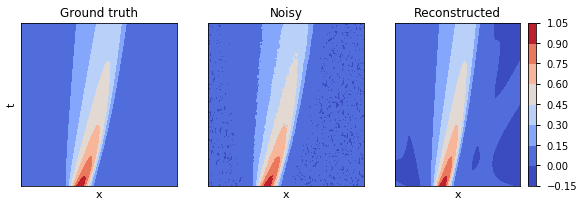

In [11]:
vmin = data['ground truth'].min()
vmax =data['ground truth'].max()

fig, [ax1, ax2, ax3] = plt.subplots(ncols=3, nrows=1, figsize= (9.5, 3))
np.count_nonzero(~np.isnan(data['train set']))

im1 = ax1.contourf(data.pivot(index='t_grid', columns='x_grid', values='ground truth'), cmap='coolwarm',vmin=vmin, vmax=vmax)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_xlabel('x')
ax1.set_ylabel('t')
ax1.set_title('Ground truth')

im2 = ax2.contourf(data.pivot(index='t_grid', columns='x_grid', values='noisy'), cmap='coolwarm', vmin=vmin, vmax=vmax)
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_xlabel('x')
ax2.set_title('Noisy')

im3 = ax3.contourf(data.pivot(index='t_grid', columns='x_grid', values='inferred'), cmap='coolwarm', vmin=vmin, vmax=vmax)
ax3.set_xticks([])
ax3.set_yticks([])
ax3.set_xlabel('x')
ax3.set_title('Reconstructed')
plt.colorbar(im3)